# 1. Peptide spectrum prediction with MS²PIP

## Peptide fragmentation spectra

The intact mass of a peptide does not provide sufficient information to identify it in a complex sample. For instance, the peptides `ACDEK` and `EDCAK` share the same amino acid composition and have the exact same mass. As a result, these peptides are indistinguishable based on their intact mass alone (they are isomeric). More information on the peptide is therefore required.

Through peptide fragmentation, we can break a peptide into various fragment ions, each representing a part of the peptide sequence. Fragmentation takes place in the collision cell of the mass spectrometer and can be performed by colliding the peptides with an inert gas, such as argon. The resulting fragment ions are then acquired in the MS2 scan, making up the peptide fragmentation spectrum.

![LC-MS DDA overview](./images/1.1-lcms-dda-overview.png)

_Figure 1.1 Overview of a data-dependent mass spectrometry workflow with peptide fragmentation_

Using the Universal Spectrum Identifier<sup>[1]</sup>, we can directoy download spectra from the PRIDE Archive. This spectrum was identified as peptide `VLHPLEGAVVIIFK` with precursor charge 2:

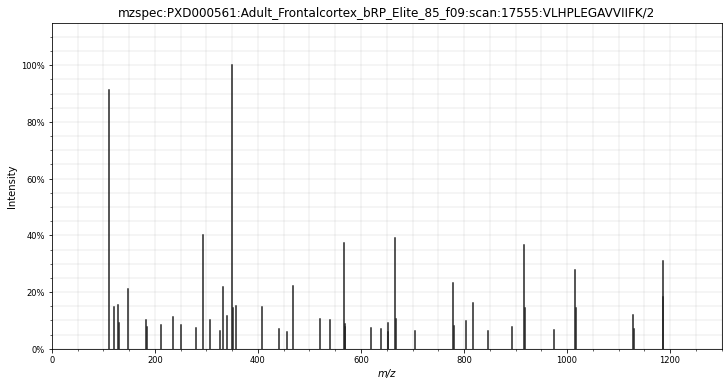

In [1]:
from scripts.ms2pip_utils import plot_unannotated_usi_spectrum

plot_unannotated_usi_spectrum(
    "mzspec:PXD000561:Adult_Frontalcortex_bRP_Elite_85_f09:scan:17555:VLHPLEGAVVIIFK/2"
)

**How do we know that this is the spectrum for peptide `VLHPLEGAVVIIFK`?**

The most common fragment ion types from the _HCD_ and _CID_ fragmentation techniques are "b" and "y" ions. Each of these ions are the result of "breaking" the peptide in two parts. Depending on the location of the breakage along the peptide backbone, different b- or y-ion will be generated:

![image](https://www.bioinfor.com/wp-content/uploads/2016/11/denovo-screenshot.png)

_Figure 1.2 Example of peptide fragmentation._

As we know the masses of each amino acid, we can simply calculate the mass of each expected b- and y-ion for any given peptide. To calculate the mass of a b-ion, simply sum the masses of all amino acid residues and the mass of a proton; to calculate the mass of a y-ion, sum the masses of all amino acid residues and add the mass of a proton and H<sub>2</sub>O.

For example, the masses of the ion b<sub>2</sub> and the ion y<sub>7</sub> for the peptide in Figure 1.2 are:

In [19]:
from pyteomics.mass import nist_mass, std_aa_mass, calculate_mass

h2o_mass = nist_mass["H"][0][0] * 2 + nist_mass["O"][0][0]
proton_mass = nist_mass["H"][0][0]

b2_mass = std_aa_mass["A"] + std_aa_mass["N"] + proton_mass
y2_mass = sum([std_aa_mass[aa] for aa in "ELLLNVK"]) + proton_mass + h2o_mass 

print("b2 =", b2_mass, "Da")
print("y2 =", y2_mass, "Da")

b2 = 186.08786503207 Da
y2 = 828.5194597157698 Da


These numbers should match the annotations in Figure 1.2.

The Python package `pyteomics`<sup>[2]</sup> contains a function that can calculate the mass of any peptide ion:

In [20]:
calculate_mass(sequence="ELLLNVK", ion_type="y", charge=1)

828.51893053796

Using these formulae, we can calculate a full _theoretical fragmentation spectrum_. Such a spectrum shows us where to expect peaks and where not. This information helps us to identify an MS2 spectrum. The theoretical spectrum for our downloaded spectrum from PRIDE Archive would contain the following b-ions:

In [50]:
peptide = "VLHPLEGAVVIIFK"

for i, amino_acid in enumerate(peptide[:-1]):
    ion_mass = calculate_mass(sequence=peptide[:i+1], ion_type="b", charge=1)    
    print(f"b{i+1}\t{ion_mass:.2f} Da\t", peptide[:i+1])

b1	100.08 Da	 V
b2	213.16 Da	 VL
b3	350.22 Da	 VLH
b4	447.27 Da	 VLHP
b5	560.36 Da	 VLHPL
b6	689.40 Da	 VLHPLE
b7	746.42 Da	 VLHPLEG
b8	817.46 Da	 VLHPLEGA
b9	916.53 Da	 VLHPLEGAV
b10	1015.59 Da	 VLHPLEGAVV
b11	1128.68 Da	 VLHPLEGAVVI
b12	1241.76 Da	 VLHPLEGAVVII
b13	1388.83 Da	 VLHPLEGAVVIIF


The full theoretical spectrum looks like this:

In [ ]:
ms2pip = SinglePrediction()
mz, _, annotations = ms2pip.predict("VLHPLEGAVVIIFK", modifications="-", charge=2)

...

### References:
[1] Deutsch, E. W., Perez-Riverol, Y., Carver, J., Kawano, S. Mendoza, L., van den Bossche, T., Gabriels, R., Binz, P.-A., Pullman, B., Sun, Z., Shofstahl, J., Bittremieux, W., Mak, T. D., Klein, J., Zhu, Y., Lam, H., Vizcaíno, J. A., &#38; Bandeira, N. (2021). Universal Spectrum Identifier for mass spectra. <i>Nature Methods</i>, 1–3. https://doi.org/10.1038/s41592-021-01184-6

[2] Levitsky, L. I., Klein, J. A., Ivanov, M. v., &#38; Gorshkov, M. v. (2019). Pyteomics 4.0: Five Years of Development of a Python Proteomics Framework. <i>Journal of Proteome Research</i>, <i>18</i>(2), 709–714. https://doi.org/10.1021/ACS.JPROTEOME.8B00717/